In [1]:
import cv2
import torch
from torchvision import transforms

from cv2 import CascadeClassifier
from PIL import Image

import torch.nn.functional as F

In [2]:
# Loading the Pre-Trained Model
model = torch.load('Model.pt')
model.eval

<bound method Module.eval of SiameseNeuralNetwork(
  (conv1): Sequential(
    (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv2): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv3): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (fc1): Sequential(
    (0): Linear(in_features=8192, out_features=512, bias=True)
    (1): ReLU(inplace=True)
    (2): Dropout(p=0.5, inplace=False)
  )
  (fc2): Sequential(
    (0): Linear(in_features=512, out_features=256, bias=True)
    (1): ReLU(inplace=True)
    (2): Dropout(p=0.5, inplace=False)
  

In [64]:
# Identifying the Face
def identify(img) :
    classifier = CascadeClassifier('haarcascade_frontalface_default.xml')
    x, y, width, height = classifier.detectMultiScale(img, minNeighbors = 5)[0]
    return cv2.cvtColor(img[y : (y + height)][x : (x + width)], cv2.COLOR_BGR2GRAY)

# Reading the Known and Unknown Image
imgA = cv2.imread('Images/Ronaldo.jpeg')
imgB = cv2.imread('Images/Messi.jpeg')

imgA = identify(imgA)
imgB = identify(imgB)

# Converting the NumPy array into an Image
imgA = Image.fromarray(imgA)
imgB = Image.fromarray(imgB)

# Applying transformation to Resize (64, 64) and Converting the Images into an Tensor
trnfrms = transforms.Compose([transforms.Resize((64, 64)), transforms.ToTensor()])

imgA = trnfrms(imgA)
imgB = trnfrms(imgB)

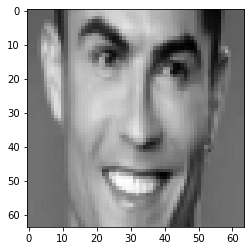

In [65]:
import matplotlib.pyplot as plt

plt.imshow(imgB[0], cmap = 'gray')
plt.show()

In [66]:
class ContrastiveLoss() :
    def __init__(self, margin = 1.0) :
        self.margin = margin

    def __call__(self, output1, output2, label) :
        euclidean_distance = F.pairwise_distance(output1, output2)
        loss_contrastive = torch.mean((label) * torch.pow(euclidean_distance, 2) + (1 - label) * torch.pow(torch.clamp(self.margin - euclidean_distance, min = 0.0), 2))
        return loss_contrastive

In [237]:
outputA = model(imgA)
outputB = model(imgB)

criterion = ContrastiveLoss()
print(criterion(outputA, outputB, torch.tensor(1.)))

tensor(0.1279, grad_fn=<MeanBackward0>)
